### 🧩 Needed Imports


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os, json
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import recall_score, precision_score

### Classification


In [2]:
def aggregate_taskset_features(df: pd.DataFrame, include_ml_engineered_features: bool = False,
                               include_schedulable: bool = False) -> pd.DataFrame:
    df = df.copy()

    # Derived per-task features (always computed, but may or may not be aggregated)
    df['criticality'] = df['C'] / df['D']
    df['interference'] = df['C'] / df['T']
    df['harmonicity'] = df.groupby('taskset_id')['T'].transform(lambda x: len(set(x)) / len(x))

    # Base aggregation functions
    agg_funcs = {
        'C': ['mean', 'max', 'min', 'std'],
        'D': ['mean', 'max', 'min', 'std'],
        'U': ['mean', 'max', 'min', 'std'],
        'inv_T': ['mean', 'std'],
        'hp_util': ['mean', 'std'],
        'U_total': 'first',
        'n_tasks': 'first'
    }

    # Optional ML-engineered features
    if include_ml_engineered_features:
        agg_funcs['criticality'] = 'mean'
        agg_funcs['interference'] = 'max'
        agg_funcs['harmonicity'] = 'mean'

    if include_schedulable:
        agg_funcs['schedulable'] = lambda x: 1 if all(x == 1) else 0

    # Group and aggregate
    df_grouped = df.groupby("taskset_id").agg(agg_funcs)

    # Clean column names
    df_grouped.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_grouped.columns.values]
    if include_schedulable:
        df_grouped.rename(columns={'schedulable_<lambda>': 'schedulable'}, inplace=True)
    df_grouped.reset_index(drop=True, inplace=True)

    return df_grouped

In [3]:
def prepare_dataset_classification(csv_path: str, include_ml_engineered_features: bool = False):
    df = pd.read_csv(csv_path)
    df_grouped = aggregate_taskset_features(
        df,
        include_ml_engineered_features=include_ml_engineered_features,
        include_schedulable=True
    )
    X = df_grouped.drop(columns=["schedulable"])
    y = df_grouped["schedulable"]
    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [6]:
def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def train_classification_models(X_train, y_train, model_type, variant: str = "default"):
    if model_type == "random_forest":
        clf = RandomForestClassifier(
            n_estimators=100, max_depth=10, class_weight='balanced',
            random_state=42, n_jobs=-1
        )
        pipeline = Pipeline([('clf', clf)])

    elif model_type == "logistic_regression":
        clf = LogisticRegression(
            max_iter=1000, class_weight='balanced', random_state=42
        )
        pipeline = Pipeline([('scaler', StandardScaler()), ('clf', clf)])

    elif model_type == "xgboost":
        spw = (y_train == 0).sum() / max(1, (y_train == 1).sum())
        clf = XGBClassifier(
            n_estimators=100, max_depth=6,
            scale_pos_weight=spw,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )
        pipeline = Pipeline([('clf', clf)])

    else:
        raise ValueError("Unsupported model type")

    # cross-validate BEFORE final fit (keeps results identical, avoids redundant fit)
    cv_scores_acc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores_auc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc',  n_jobs=-1)

    # final fit on full training split
    pipeline.fit(X_train, y_train)

    # save CV results (preserve existing keys used by evaluate_models)
    outdir = "../models/classification_models"
    _ensure_dir(outdir)
    cv_results = {
        "model": model_type,
        "variant": variant,
        "cv_mean_accuracy": float(cv_scores_acc.mean()),
        "cv_std": float(cv_scores_acc.std()),
        "cv_scores": cv_scores_acc.tolist(),
        "cv_mean_roc_auc": float(cv_scores_auc.mean()),
        "cv_std_roc_auc": float(cv_scores_auc.std()),
        "cv_scores_roc_auc": cv_scores_auc.tolist()
    }
    with open(os.path.join(outdir, f"{model_type}_{variant}_cv.json"), "w") as f:
        json.dump(cv_results, f, indent=2)

    return pipeline


In [28]:
def _get_cv_string(cv_path: str) -> str:
    if not os.path.exists(cv_path):
        return "N/A"
    with open(cv_path, "r") as f:
        cv = json.load(f)
    mean_acc = cv.get("cv_mean_accuracy", cv.get("cv_mean"))
    std_acc  = cv.get("cv_std_accuracy",  cv.get("cv_std"))
    mean_auc = cv.get("cv_mean_roc_auc")
    std_auc  = cv.get("cv_std_roc_auc")

    parts = []
    if mean_acc is not None and std_acc is not None:
        parts.append(f"Acc {mean_acc:.4f} ± {std_acc:.4f}")
    if mean_auc is not None and std_auc is not None:
        parts.append(f"AUC {mean_auc:.4f} ± {std_auc:.4f}")
    return "; ".join(parts) if parts else "N/A"

def evaluate_models(X_test, y_test, model_paths, variant="default"):
    results = []

    # --- ROC overlay ---
    plt.figure(figsize=(8, 6))

    for model_name, model_path in model_paths.items():
        pipeline = joblib.load(model_path)

        # Predictions / scores
        y_pred  = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        # Metrics
        acc     = accuracy_score(y_test, y_pred)
        f1      = f1_score(y_test, y_pred)
        prec    = precision_score(y_test, y_pred, zero_division=0)
        rec     = recall_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba)
        conf    = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = conf.ravel()

        # CV string (backward compatible with older JSON keys)
        cv_path = f"../models/classification_models/{model_name}_{variant}_cv.json"
        cv_info = _get_cv_string(cv_path)

        # Accumulate table row
        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC-AUC": roc_auc,
            "FP": int(fp),
            "FN": int(fn),
            "CV": cv_info
        })

        # ROC curve overlay
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")

        # Console summary
        print(f"\n=== {model_name.upper()} ===")
        print(f"CV: {cv_info}")
        print("Confusion Matrix:\n", conf)
        print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

        # --- Confusion Matrix plot ---
        plt_cm = plt.figure(figsize=(5, 4))
        sns.heatmap(conf, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["True 0", "True 1"])
        plt.title(f"Confusion Matrix: {model_name}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")

        # Save separately for Chapter 4 (Figure 4.2)
        _ensure_dir("../figures/confusion_matrices")
        plt.savefig(f"../figures/confusion_matrices/{model_name}_{variant}_cm.png", dpi=200)
        plt.close(plt_cm)

    # Random baseline
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save ROC overlay for Chapter 4 (Figure 4.1)
    _ensure_dir("../figures")
    plt.savefig("../figures/clf_roc_overlay.png", dpi=200)
    plt.show()

    # Final metrics table for Chapter 4 (Table 4.1)
    df_results = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)

    return df_results

def show_confusion_matrix(model_path, X_test, y_test, title="Confusion Matrix"):
    import joblib
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import numpy as np

    # Load trained model
    pipeline = joblib.load(model_path)

    # Predict labels
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im, ax=ax)

    # Titles and labels
    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Unschedulable", "Schedulable"])
    ax.set_yticklabels(["Unschedulable", "Schedulable"])

    # Custom labels
    labels = [
        f"TN = {tn}", f"FP = {fp}",
        f"FN = {fn}", f"TP = {tp}"
    ]
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    # Normalize colors for contrast check
    max_val = cm.max()
    for (i, j), label, val in zip(positions, labels, [tn, fp, fn, tp]):
        # Choose text color: white if dark background, black if light
        color = "white" if val > max_val / 2 else "black"
        ax.text(j, i, label,
                ha="center", va="center", color=color,
                fontsize=11, weight="bold")

    plt.tight_layout()
    plt.show()

    return cm, (tn, fp, fn, tp)





🔍 STEP 1: Training Models WITHOUT ML-Engineered Features
📦 random_forest (basic) already trained.
📦 logistic_regression (basic) already trained.
📦 xgboost (basic) already trained.

=== RANDOM_FOREST ===
CV: Acc 0.8440 ± 0.0014; AUC 0.9281 ± 0.0007
Confusion Matrix:
 [[132174  26497]
 [  4852  36477]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9646    0.8330    0.8940    158671
           1     0.5792    0.8826    0.6994     41329

    accuracy                         0.8433    200000
   macro avg     0.7719    0.8578    0.7967    200000
weighted avg     0.8850    0.8433    0.8538    200000


=== LOGISTIC_REGRESSION ===
CV: Acc 0.8476 ± 0.0012; AUC 0.9341 ± 0.0008
Confusion Matrix:
 [[132643  26028]
 [  4284  37045]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9687    0.8360    0.8975    158671
           1     0.5873    0.8963    0.7097     41329

    accuracy                   

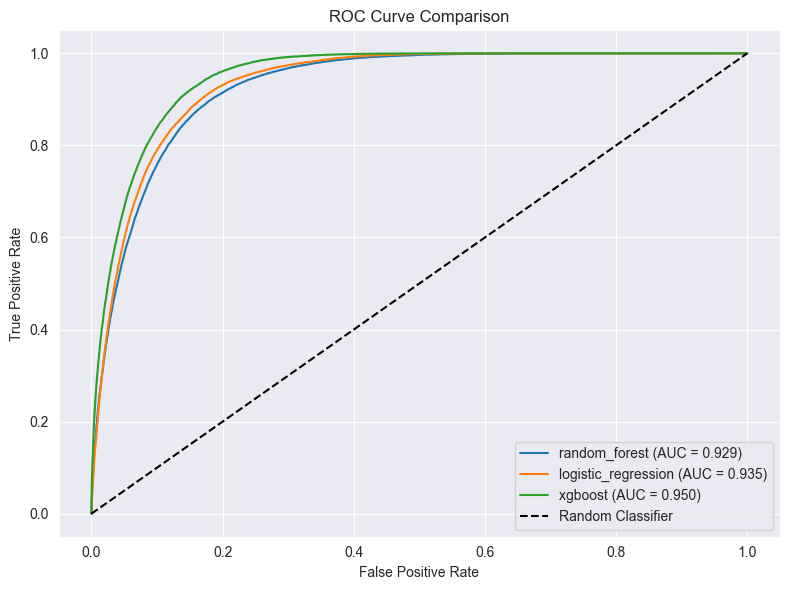


🧪 Evaluation (No Engineered Features)
--------------------------------------------------
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0              xgboost  0.866585   0.619990  0.915531  0.739319  0.950163   
1  logistic_regression  0.848440   0.587335  0.896344  0.709661  0.934953   
2        random_forest  0.843255   0.579239  0.882601  0.699443  0.928633   

      FP    FN                                        CV  
0  23192  3491  Acc 0.8657 ± 0.0010; AUC 0.9493 ± 0.0005  
1  26028  4284  Acc 0.8476 ± 0.0012; AUC 0.9341 ± 0.0008  
2  26497  4852  Acc 0.8440 ± 0.0014; AUC 0.9281 ± 0.0007  



🔬 STEP 2: Training Models WITH ML-Engineered Features
📦 random_forest (engineered) already trained.
📦 logistic_regression (engineered) already trained.
📦 xgboost (engineered) already trained.

=== RANDOM_FOREST ===
CV: Acc 0.8924 ± 0.0009; AUC 0.9684 ± 0.0006
Confusion Matrix:
 [[140182  18489]
 [  2755  38574]]
Classification Report:
               precision 

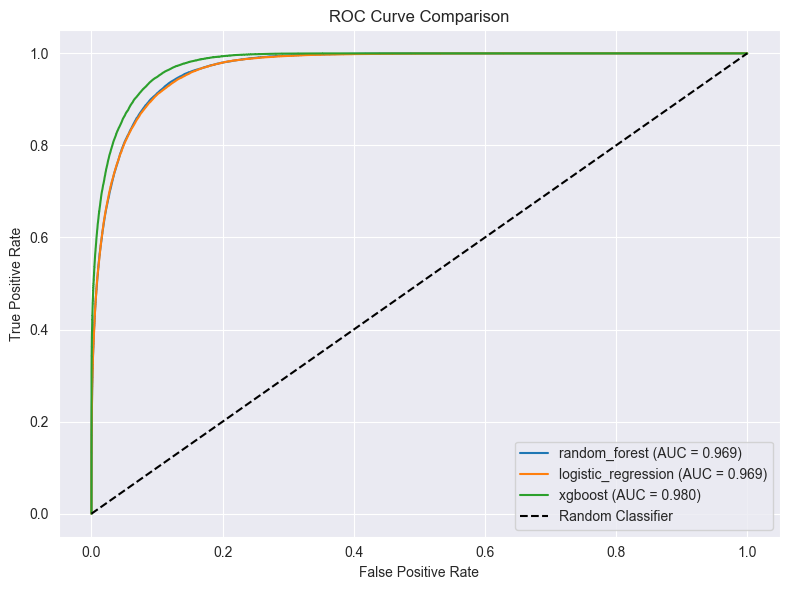


🧪 Evaluation (With Engineered Features)
--------------------------------------------------
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
0              xgboost  0.913950   0.724183  0.942583  0.819074  0.979609   
1        random_forest  0.893780   0.675990  0.933340  0.784088  0.969478   
2  logistic_regression  0.894935   0.681225  0.923903  0.784219  0.968926   

      FP    FN                                        CV  
0  14837  2373  Acc 0.9129 ± 0.0008; AUC 0.9791 ± 0.0004  
1  18489  2755  Acc 0.8924 ± 0.0009; AUC 0.9684 ± 0.0006  
2  17868  3145  Acc 0.8941 ± 0.0012; AUC 0.9683 ± 0.0004  


In [10]:
# --- Step 1: Basic Features (No ML-Engineered Features)
print("=" * 50)
print("🔍 STEP 1: Training Models WITHOUT ML-Engineered Features")
print("=" * 50)

MODELS_DIR = "../models/classification_models"
os.makedirs(MODELS_DIR, exist_ok=True)

X_train_basic, X_test_basic, y_train_basic, y_test_basic = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=False
)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = os.path.join(MODELS_DIR, f"{model_type}_basic.pkl")
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (basic)...")
        pipeline = train_classification_models(X_train_basic, y_train_basic, model_type, variant="basic")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (basic) already trained.")

results_basic = evaluate_models(
    X_test_basic, y_test_basic,
    {
        "random_forest": os.path.join(MODELS_DIR, "random_forest_basic.pkl"),
        "logistic_regression": os.path.join(MODELS_DIR, "logistic_regression_basic.pkl"),
        "xgboost": os.path.join(MODELS_DIR, "xgboost_basic.pkl"),
    },
    variant="basic"
)

print("\n🧪 Evaluation (No Engineered Features)")
print("-" * 50)
print(results_basic)
print("\n\n")

# --- Step 2: With Engineered Features
print("=" * 50)
print("🔬 STEP 2: Training Models WITH ML-Engineered Features")
print("=" * 50)

X_train_eng, X_test_eng, y_train_eng, y_test_eng = prepare_dataset_classification(
    "../data/main_dataset.csv", include_ml_engineered_features=True
)

for model_type in ["random_forest", "logistic_regression", "xgboost"]:
    model_path = os.path.join(MODELS_DIR, f"{model_type}_engineered.pkl")
    if not os.path.exists(model_path):
        print(f"🚀 Training {model_type} (engineered)...")
        pipeline = train_classification_models(X_train_eng, y_train_eng, model_type, variant="engineered")
        joblib.dump(pipeline, model_path)
    else:
        print(f"📦 {model_type} (engineered) already trained.")

results_eng = evaluate_models(
    X_test_eng, y_test_eng,
    {
        "random_forest": os.path.join(MODELS_DIR, "random_forest_engineered.pkl"),
        "logistic_regression": os.path.join(MODELS_DIR, "logistic_regression_engineered.pkl"),
        "xgboost": os.path.join(MODELS_DIR, "xgboost_engineered.pkl"),
    },
    variant="engineered"
)

print("\n🧪 Evaluation (With Engineered Features)")
print("-" * 50)
print(results_eng)

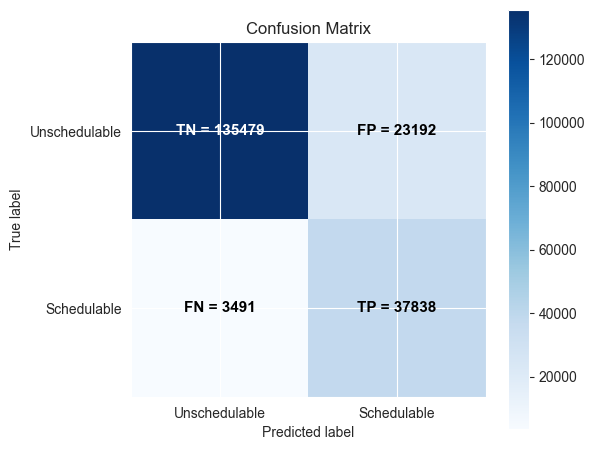

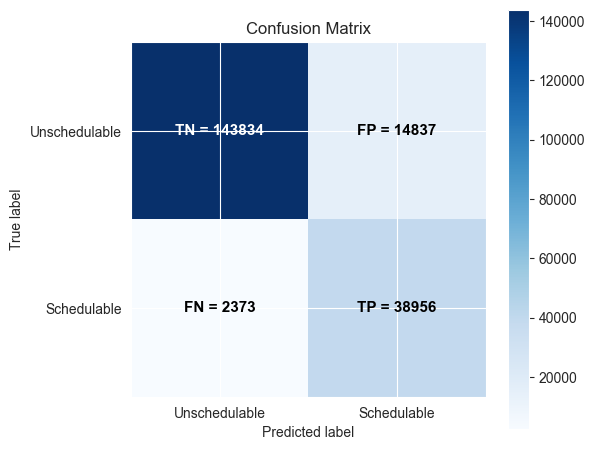

(array([[143834,  14837],
        [  2373,  38956]]),
 (np.int64(143834), np.int64(14837), np.int64(2373), np.int64(38956)))

In [29]:
show_confusion_matrix(MODELS_DIR+"/xgboost_basic.pkl", X_test_basic, y_test_basic)
show_confusion_matrix(MODELS_DIR+"/xgboost_engineered.pkl", X_test_eng, y_test_eng)

In [21]:
# STEP 1: Evaluate Thresholds + Safety Metrics
def evaluate_with_threshold(X_test, y_test, pipeline, save_path="../figures/threshold_optimization.png"):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.5, 0.99, 20)

    best_threshold = 0.5
    best_fp = float('inf')
    best_f1 = 0.0
    logs = []

    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        f1 = f1_score(y_test, y_pred)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        underrisk = fp / len(y_test)

        # Pick threshold with lowest FP while keeping F1 > 0.6
        if fp < best_fp and f1 > 0.6:
            best_fp, best_f1, best_threshold = fp, f1, thresh

        logs.append({
            'Threshold': round(thresh, 2),
            'True Positives': tp,
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'F1 Score': f1,
            'Precision': precision,
            'Underestimation Risk': underrisk
        })

    # Convert to DataFrame
    logs_df = pd.DataFrame(logs)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(logs_df["Threshold"], logs_df["False Positives"], label="False Positives")
    plt.plot(logs_df["Threshold"], logs_df["F1 Score"], label="F1 Score")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.2f}")
    plt.title("Threshold Optimization for Safety")
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()

    return logs_df, best_threshold


# STEP 2: Run Entire Pipeline
def run_pipeline(csv_path):
    X_train, X_test, y_train, y_test = prepare_dataset_classification(
        csv_path, include_ml_engineered_features=True
    )
    model = joblib.load("../models/classification_models/xgboost_engineered.pkl")
    logs_df, best_threshold = evaluate_with_threshold(X_test, y_test, model)
    return logs_df, best_threshold, model, X_test, y_test


# === RUN ===
logs_df, best_threshold, model, X_test, y_test = run_pipeline("../data/main_dataset.csv")

# Show top 5 thresholds (sorted by lowest FP)
print("\n🔍 Top Threshold Results:")
print(
    logs_df[[
        "Threshold", "True Positives", "True Negatives",
        "False Positives", "False Negatives",
        "F1 Score", "Precision", "Underestimation Risk"
    ]].sort_values("False Positives").head(5)
)
print(f"\nBest Threshold: {best_threshold:.2f}")



🔍 Top Threshold Results:
    Threshold  True Positives  True Negatives  False Positives  \
19       0.99           14156          158617               54   
18       0.96           20792          158151              520   
17       0.94           24624          157490             1181   
16       0.91           27317          156780             1891   
15       0.89           29353          155944             2727   

    False Negatives  F1 Score  Precision  Underestimation Risk  
19            27173  0.509768   0.996200              0.000270  
18            20537  0.663846   0.975601              0.002600  
17            16705  0.733578   0.954234              0.005905  
16            14012  0.774544   0.935257              0.009455  
15            11976  0.799711   0.914994              0.013635  

✅ Best Threshold: 0.96
